#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model4(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, max_len=1024, dropout=0.1):
        super(Model4, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.Conv1dL = nn.Conv1d(self.max_len, 1, 1)
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Conv1dL(out).squeeze()
        out = self.DenseL2(out)
        return out

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 58.29batch/s, loss=0.212]


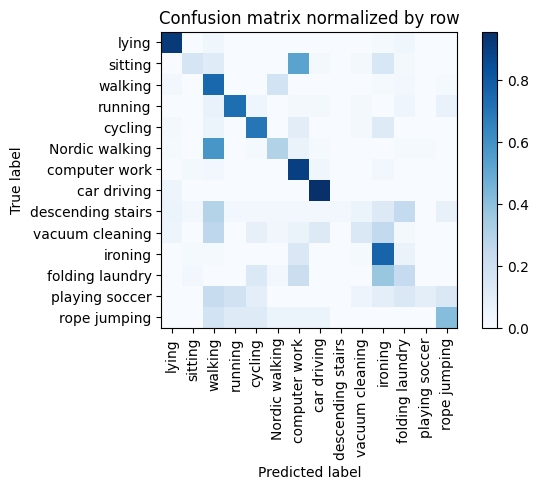

Training Epoch:  10%|█         | 1/10 [00:10<01:33, 10.37s/it]

Overall accuracy: 0.567



eval: 100%|██████████| 26/26 [00:00<00:00, 44.95batch/s, loss=0.184]


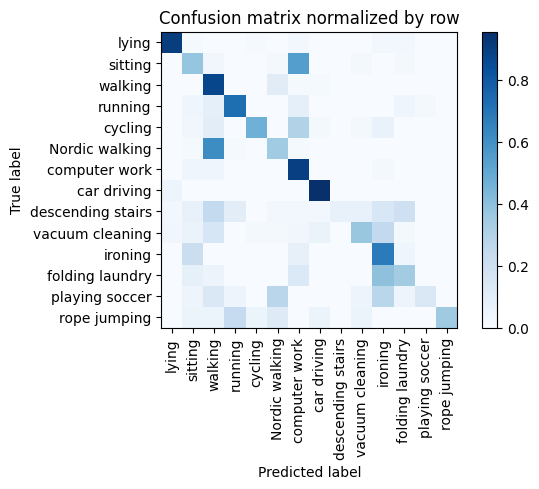

Training Epoch:  20%|██        | 2/10 [00:14<00:53,  6.69s/it]

Overall accuracy: 0.599



eval: 100%|██████████| 26/26 [00:00<00:00, 60.45batch/s, loss=0.126]


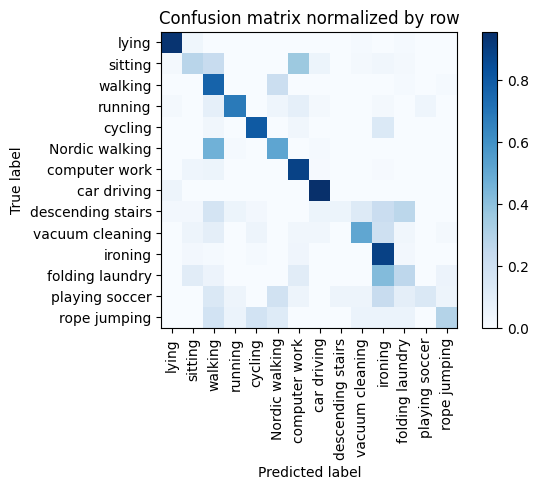

Training Epoch:  30%|███       | 3/10 [00:18<00:38,  5.48s/it]

Overall accuracy: 0.647



eval: 100%|██████████| 26/26 [00:00<00:00, 65.82batch/s, loss=0.17]


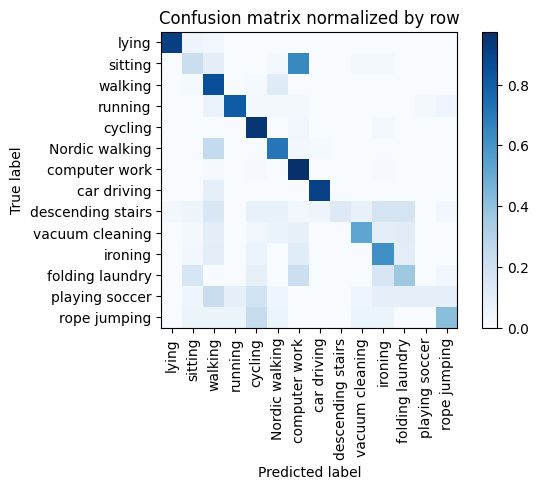

Training Epoch:  40%|████      | 4/10 [00:22<00:29,  4.87s/it]

Overall accuracy: 0.682



eval: 100%|██████████| 26/26 [00:00<00:00, 70.27batch/s, loss=0.192]


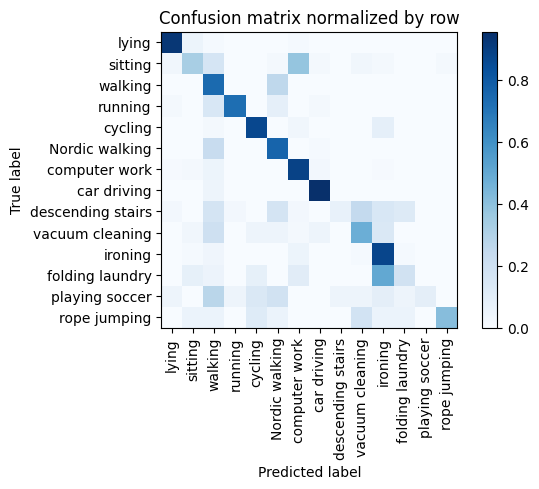

Training Epoch:  50%|█████     | 5/10 [00:26<00:22,  4.47s/it]

Overall accuracy: 0.674



eval: 100%|██████████| 26/26 [00:00<00:00, 73.24batch/s, loss=0.213]


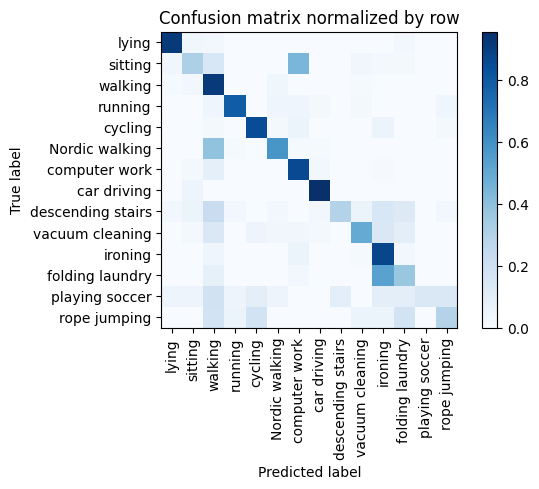

Training Epoch:  60%|██████    | 6/10 [00:30<00:17,  4.30s/it]

Overall accuracy: 0.690



eval: 100%|██████████| 26/26 [00:00<00:00, 78.79batch/s, loss=0.16]


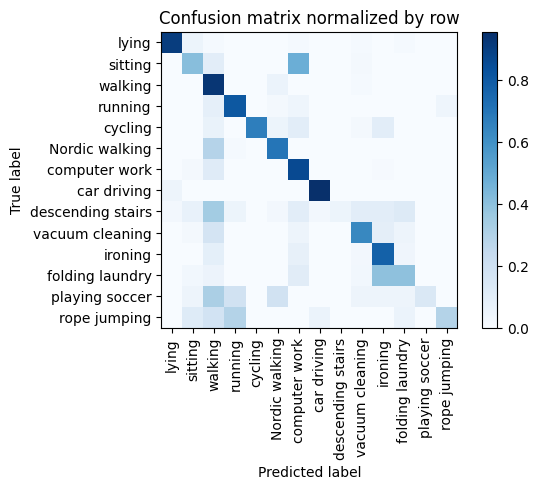

Training Epoch:  70%|███████   | 7/10 [00:34<00:12,  4.26s/it]

Overall accuracy: 0.687



eval: 100%|██████████| 26/26 [00:00<00:00, 78.19batch/s, loss=0.131]


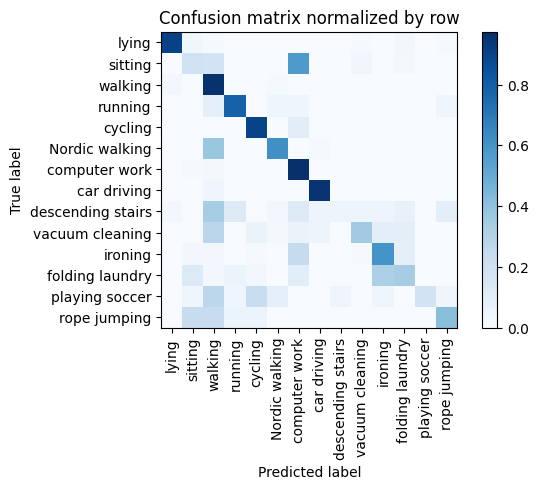

Training Epoch:  80%|████████  | 8/10 [00:38<00:08,  4.16s/it]

Overall accuracy: 0.660



eval: 100%|██████████| 26/26 [00:00<00:00, 64.68batch/s, loss=0.154]


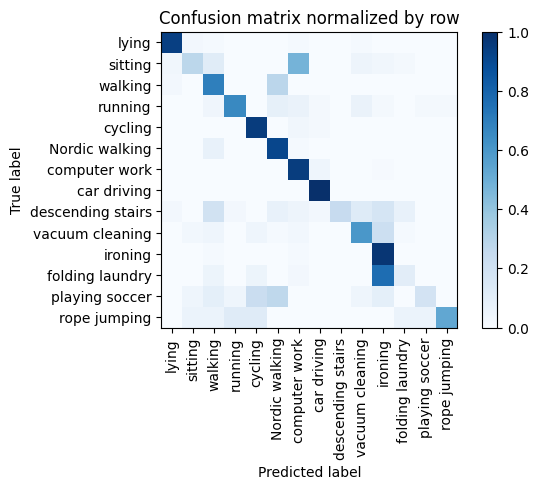

Training Epoch:  90%|█████████ | 9/10 [00:42<00:04,  4.25s/it]

Overall accuracy: 0.723



eval: 100%|██████████| 26/26 [00:00<00:00, 69.71batch/s, loss=0.151]


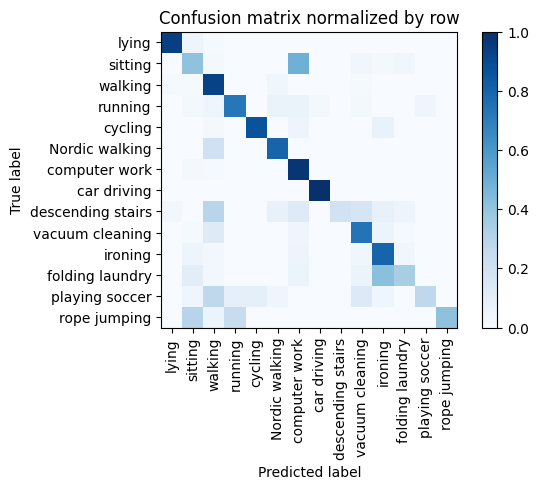

Overall accuracy: 0.750



eval: 100%|██████████| 28/28 [00:00<00:00, 79.20batch/s, loss=0.268]


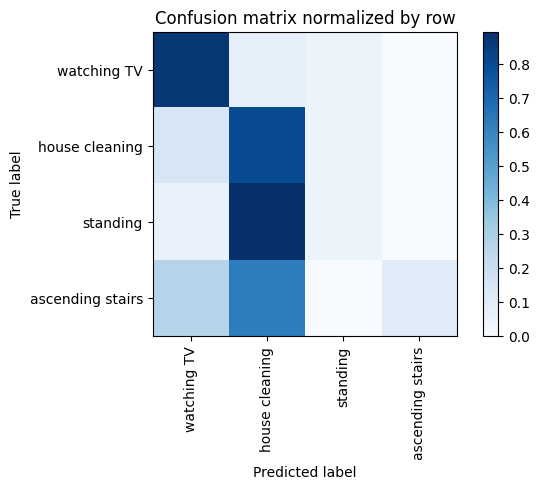

Overall accuracy: 0.426

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.381      0.801      0.516      0.328        287|	 watching TV: 0.143,	standing: 0.052,	
        standing       0.371      0.046      0.082      0.323        283|	 house cleaning: 0.894,	watching TV: 0.060,	
ascending stairs       0.947      0.102      0.184      0.202        177|	 house cleaning: 0.627,	watching TV: 0.271,	
     watching TV       0.514      0.868      0.646      0.147        129|	 house cleaning: 0.078,	standing: 0.054,	

----------------------------------------------------------------------------------------------------
     avg / total       0.512      0.426      0.328        1.0        876|	      

{'total_accuracy': 0.4257990867579909, 'precision': 0.5533382905894666, 'recall': 0.4543105233751292, 'f1': 0.35681036662365523}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'desce

eval: 100%|██████████| 26/26 [00:00<00:00, 58.82batch/s, loss=0.194]


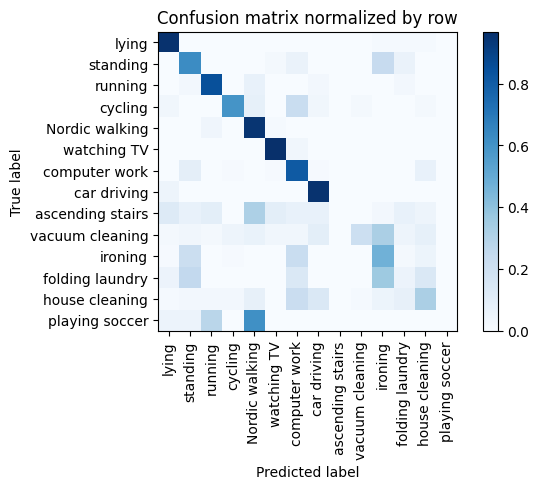

Training Epoch:  10%|█         | 1/10 [00:04<00:38,  4.25s/it]

Overall accuracy: 0.593



eval: 100%|██████████| 26/26 [00:00<00:00, 62.63batch/s, loss=0.174]


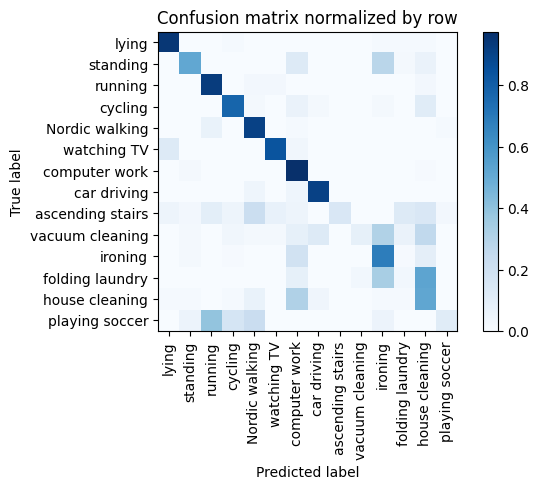

Training Epoch:  20%|██        | 2/10 [00:08<00:32,  4.06s/it]

Overall accuracy: 0.657



eval: 100%|██████████| 26/26 [00:00<00:00, 60.49batch/s, loss=0.19]


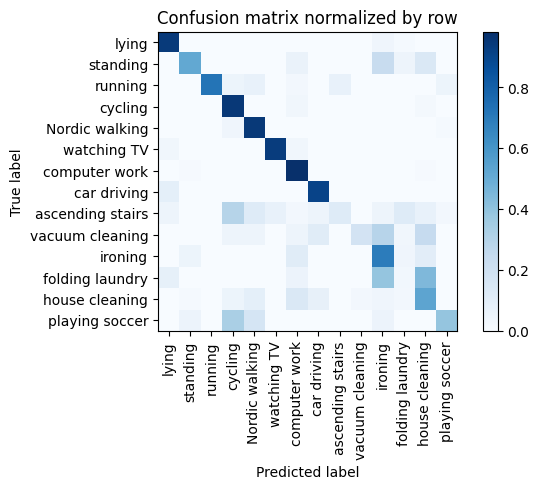

Training Epoch:  30%|███       | 3/10 [00:11<00:27,  3.95s/it]

Overall accuracy: 0.684



eval: 100%|██████████| 26/26 [00:00<00:00, 59.91batch/s, loss=0.152]


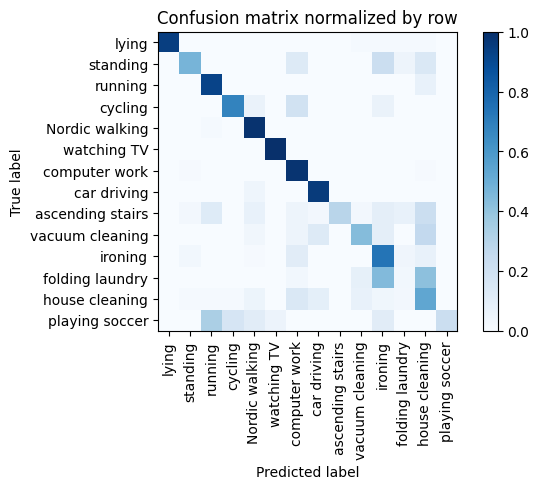

Training Epoch:  40%|████      | 4/10 [00:16<00:24,  4.01s/it]

Overall accuracy: 0.706



eval: 100%|██████████| 26/26 [00:00<00:00, 61.00batch/s, loss=0.138]


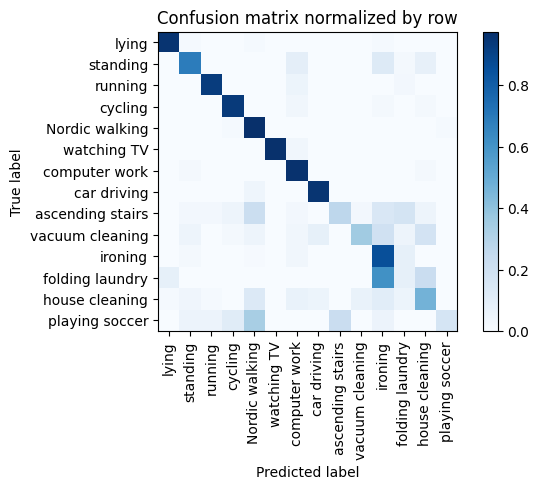

Training Epoch:  50%|█████     | 5/10 [00:19<00:19,  3.89s/it]

Overall accuracy: 0.741



eval: 100%|██████████| 26/26 [00:00<00:00, 55.44batch/s, loss=0.173]


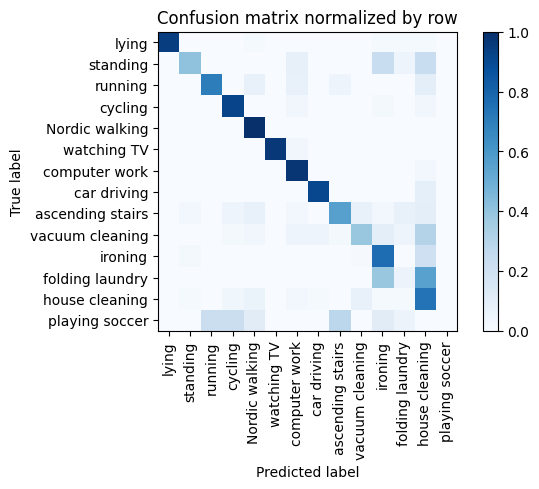

Training Epoch:  60%|██████    | 6/10 [00:23<00:15,  3.97s/it]

Overall accuracy: 0.735



eval: 100%|██████████| 26/26 [00:00<00:00, 54.50batch/s, loss=0.179]


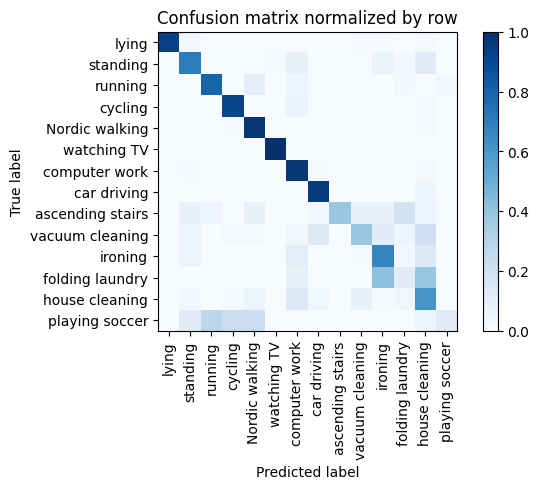

Training Epoch:  70%|███████   | 7/10 [00:28<00:12,  4.16s/it]

Overall accuracy: 0.734



eval: 100%|██████████| 26/26 [00:00<00:00, 61.61batch/s, loss=0.134]


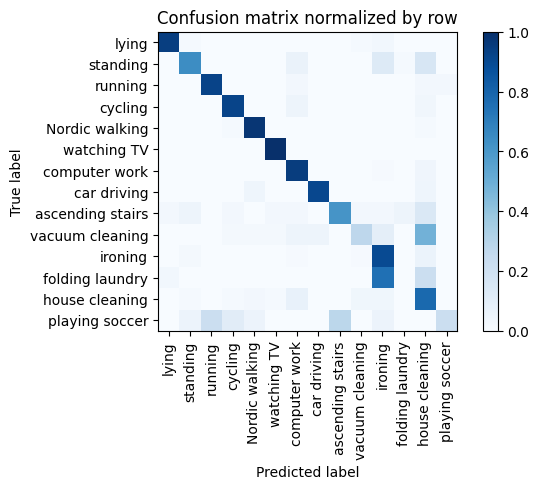

Training Epoch:  80%|████████  | 8/10 [00:32<00:08,  4.13s/it]

Overall accuracy: 0.776



eval: 100%|██████████| 26/26 [00:00<00:00, 59.50batch/s, loss=0.102]


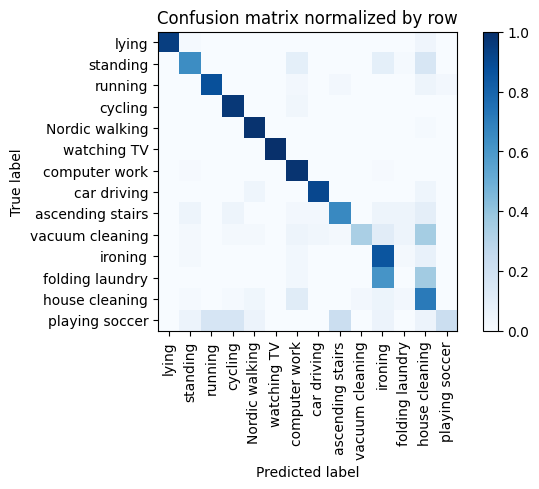

Training Epoch:  90%|█████████ | 9/10 [00:36<00:04,  4.14s/it]

Overall accuracy: 0.779



eval: 100%|██████████| 26/26 [00:00<00:00, 61.47batch/s, loss=0.112]


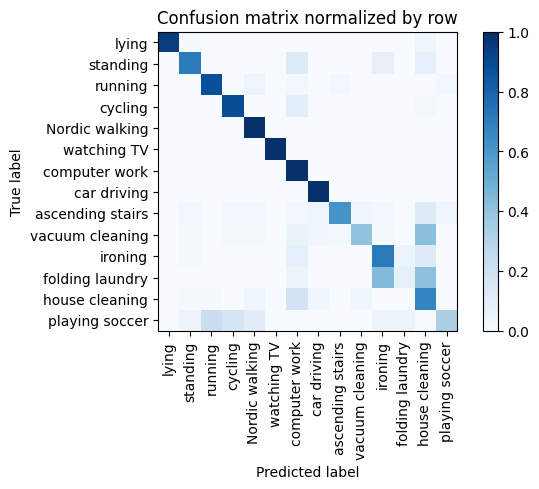

Overall accuracy: 0.772



eval: 100%|██████████| 28/28 [00:00<00:00, 97.56batch/s, loss=0.285] 


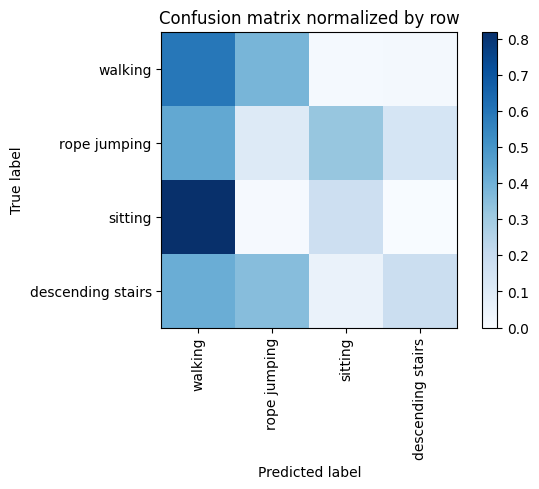

Overall accuracy: 0.349

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.407      0.592      0.483      0.427        373|	 rope jumping: 0.383,	descending stairs: 0.013,	
          sitting       0.598      0.174      0.269      0.323        282|	 walking: 0.819,	rope jumping: 0.007,	
descending stairs       0.667      0.183      0.287      0.175        153|	 walking: 0.412,	rope jumping: 0.353,	
     rope jumping       0.034      0.108      0.052      0.074         65|	 walking: 0.431,	sitting: 0.323,	descending stairs: 0.138,	

----------------------------------------------------------------------------------------------------
      avg / total       0.486      0.349      0.347        1.0        873|	      

{'total_accuracy': 0.34936998854524626, 'precision': 0.42630159579501714, 'recall': 0.2642377516188446, 'f1': 0.27265088102678137}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'l

eval: 100%|██████████| 24/24 [00:00<00:00, 65.75batch/s, loss=0.277]


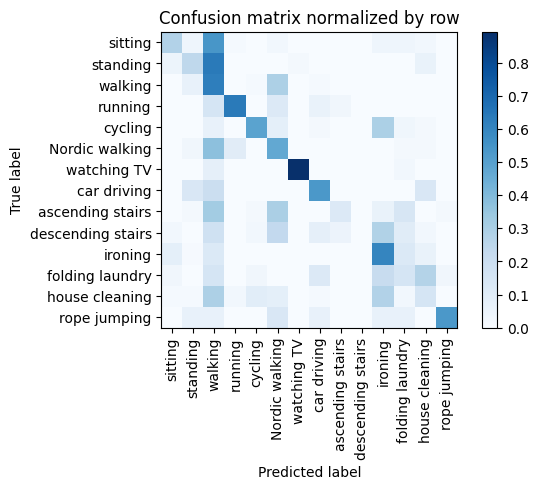

Training Epoch:  10%|█         | 1/10 [00:03<00:30,  3.43s/it]

Overall accuracy: 0.408



eval: 100%|██████████| 24/24 [00:00<00:00, 59.55batch/s, loss=0.212]


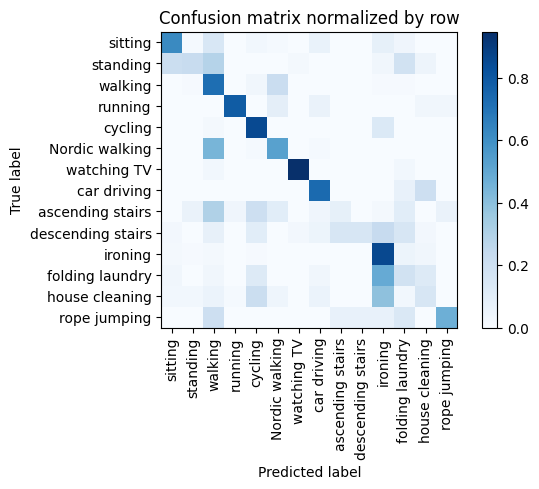

Training Epoch:  20%|██        | 2/10 [00:07<00:29,  3.64s/it]

Overall accuracy: 0.538



eval: 100%|██████████| 24/24 [00:00<00:00, 67.42batch/s, loss=0.186]


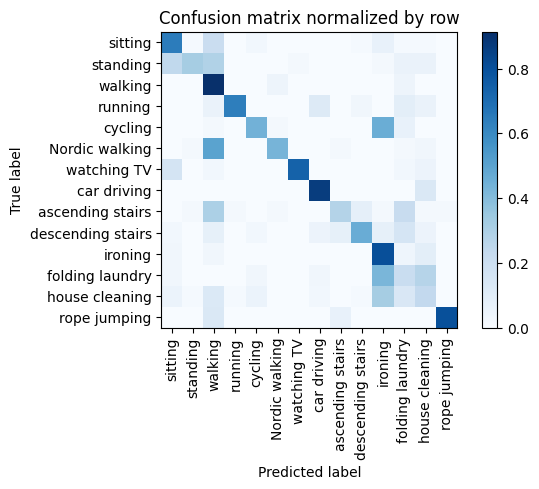

Training Epoch:  30%|███       | 3/10 [00:12<00:29,  4.18s/it]

Overall accuracy: 0.554



eval: 100%|██████████| 24/24 [00:00<00:00, 35.04batch/s, loss=0.171]


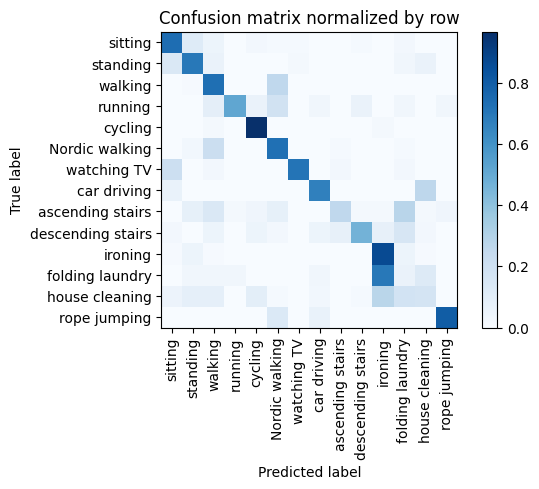

Training Epoch:  40%|████      | 4/10 [00:17<00:27,  4.53s/it]

Overall accuracy: 0.627



eval: 100%|██████████| 24/24 [00:00<00:00, 67.42batch/s, loss=0.155]


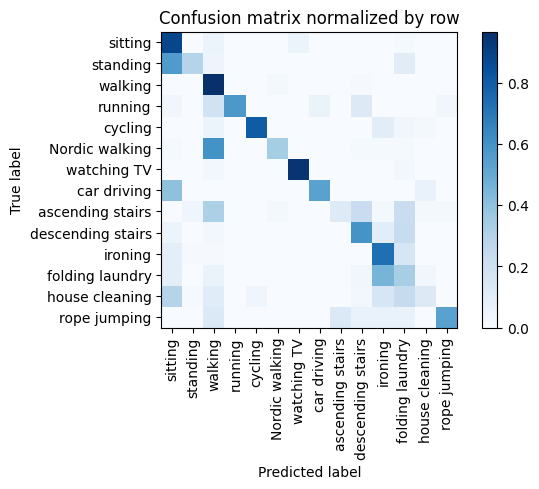

Training Epoch:  50%|█████     | 5/10 [00:20<00:20,  4.14s/it]

Overall accuracy: 0.580



eval: 100%|██████████| 24/24 [00:00<00:00, 69.36batch/s, loss=0.165]


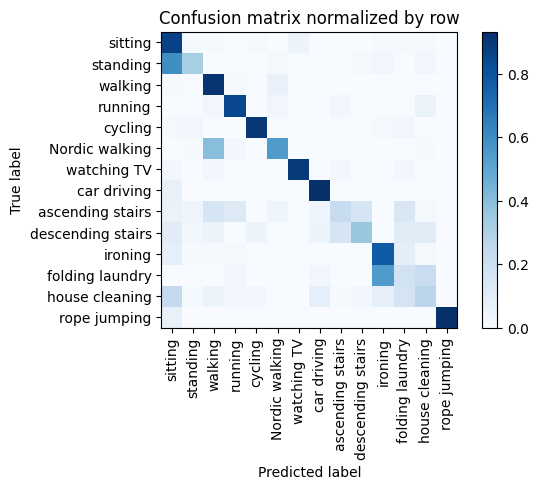

Training Epoch:  60%|██████    | 6/10 [00:23<00:15,  3.90s/it]

Overall accuracy: 0.633



eval: 100%|██████████| 24/24 [00:00<00:00, 79.47batch/s, loss=0.149]


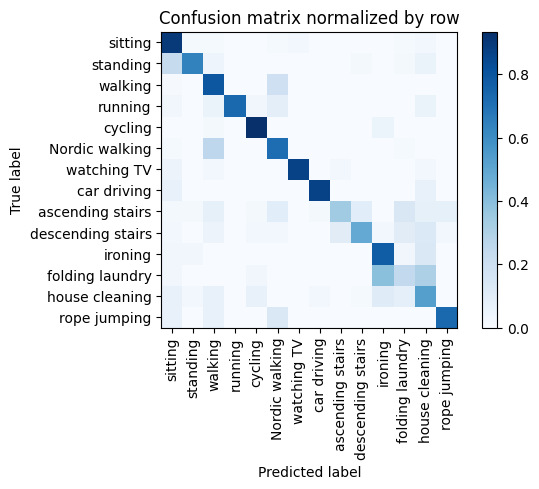

Training Epoch:  70%|███████   | 7/10 [00:27<00:10,  3.65s/it]

Overall accuracy: 0.698



eval: 100%|██████████| 24/24 [00:00<00:00, 75.23batch/s, loss=0.164]


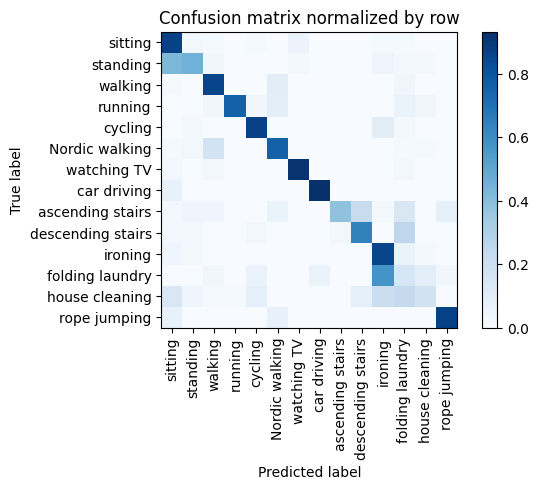

Training Epoch:  80%|████████  | 8/10 [00:30<00:07,  3.52s/it]

Overall accuracy: 0.678



eval: 100%|██████████| 24/24 [00:00<00:00, 87.27batch/s, loss=0.143]


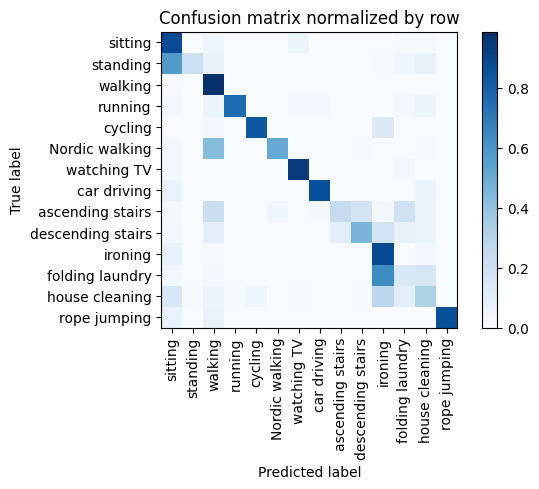

Training Epoch:  90%|█████████ | 9/10 [00:33<00:03,  3.42s/it]

Overall accuracy: 0.648



eval: 100%|██████████| 24/24 [00:00<00:00, 75.23batch/s, loss=0.132]


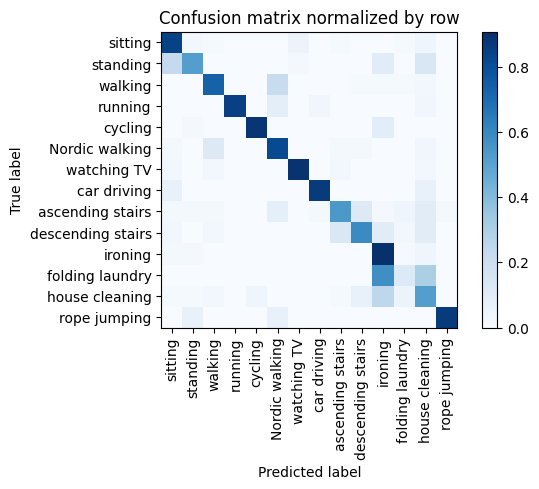

Overall accuracy: 0.718



eval: 100%|██████████| 35/35 [00:00<00:00, 105.42batch/s, loss=0.334]


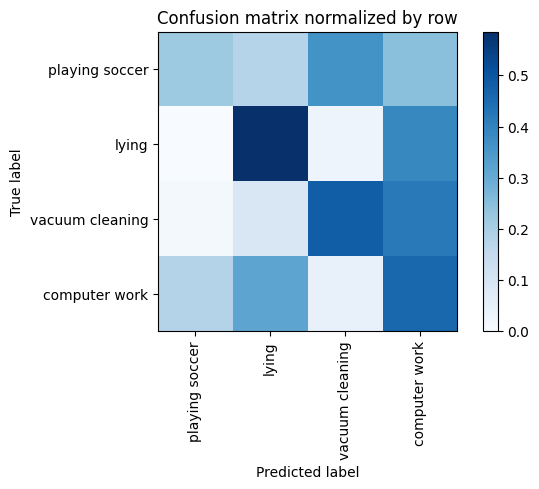

Overall accuracy: 0.483

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.476      0.461      0.469      0.432        477|	 lying: 0.317,	playing soccer: 0.180,	
          lying       0.473      0.585      0.523      0.260        287|	 computer work: 0.387,	vacuum cleaning: 0.028,	
vacuum cleaning       0.712      0.482      0.575      0.246        272|	 computer work: 0.419,	lying: 0.088,	
 playing soccer       0.144      0.217      0.173      0.062         69|	 vacuum cleaning: 0.362,	computer work: 0.246,	

----------------------------------------------------------------------------------------------------
    avg / total       0.513      0.483      0.490        1.0       1105|	      

{'total_accuracy': 0.4832579185520362, 'precision': 0.4514043009450236, 'recall': 0.4363976844948081, 'f1': 0.4349799734220931}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']


eval: 100%|██████████| 27/27 [00:00<00:00, 78.72batch/s, loss=0.276]


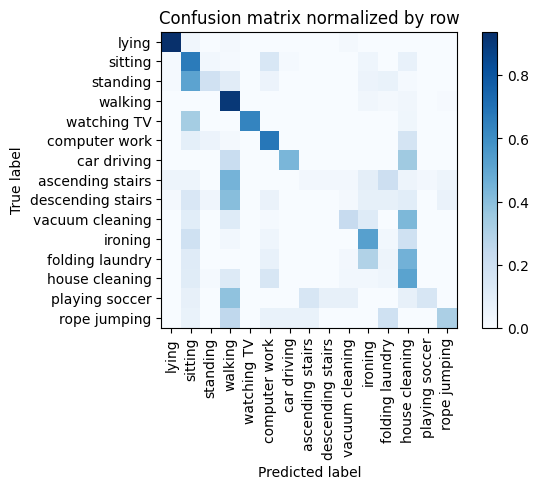

Training Epoch:  10%|█         | 1/10 [00:03<00:29,  3.25s/it]

Overall accuracy: 0.488



eval: 100%|██████████| 27/27 [00:00<00:00, 81.82batch/s, loss=0.156]


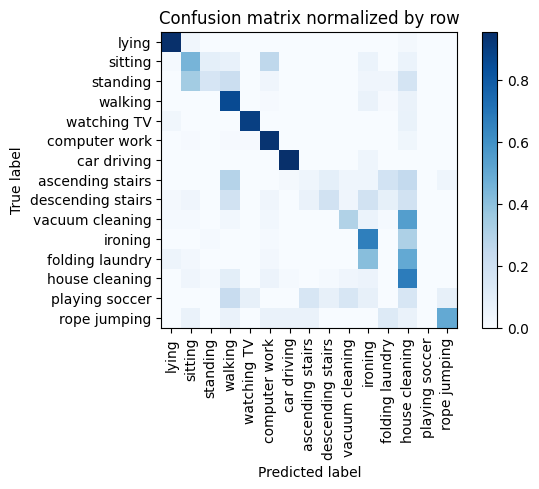

Training Epoch:  20%|██        | 2/10 [00:06<00:28,  3.51s/it]

Overall accuracy: 0.563



eval: 100%|██████████| 27/27 [00:00<00:00, 75.84batch/s, loss=0.183]


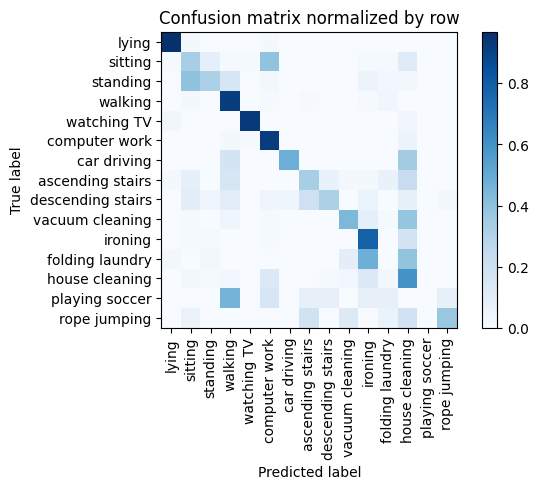

Training Epoch:  30%|███       | 3/10 [00:10<00:25,  3.67s/it]

Overall accuracy: 0.598



eval: 100%|██████████| 27/27 [00:00<00:00, 66.50batch/s, loss=0.143]


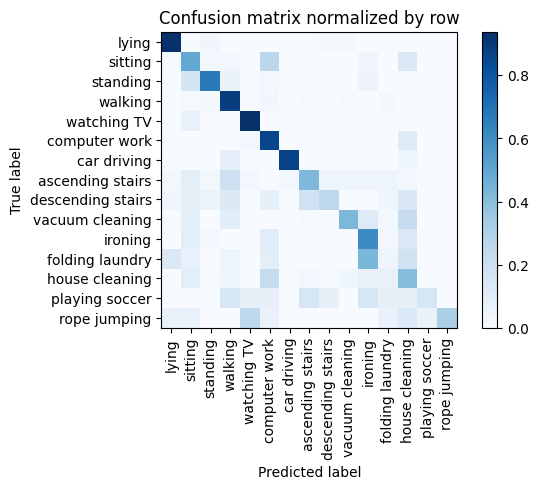

Training Epoch:  40%|████      | 4/10 [00:14<00:22,  3.67s/it]

Overall accuracy: 0.611



eval: 100%|██████████| 27/27 [00:00<00:00, 70.13batch/s, loss=0.147]


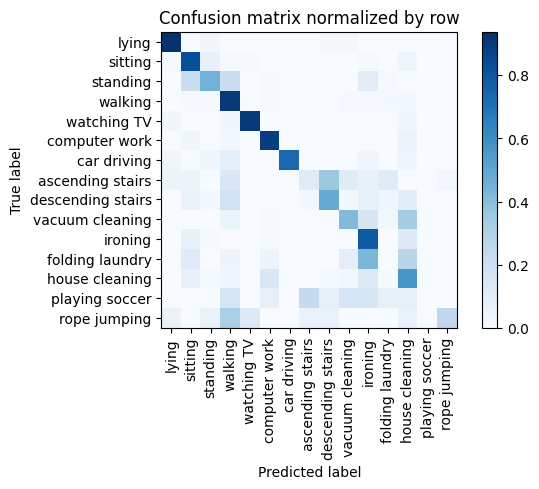

Training Epoch:  50%|█████     | 5/10 [00:18<00:18,  3.67s/it]

Overall accuracy: 0.637



eval: 100%|██████████| 27/27 [00:00<00:00, 73.17batch/s, loss=0.173]


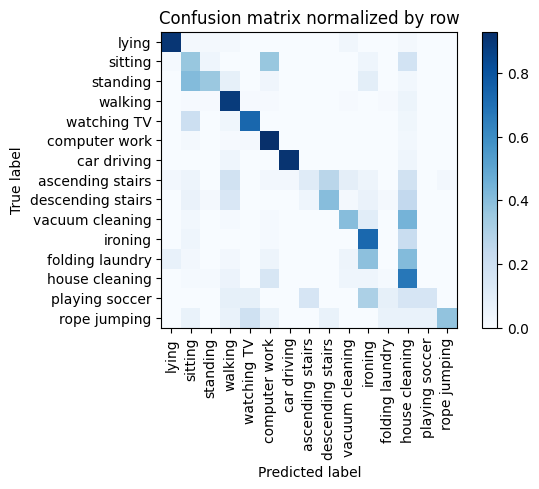

Training Epoch:  60%|██████    | 6/10 [00:21<00:14,  3.67s/it]

Overall accuracy: 0.596



eval: 100%|██████████| 27/27 [00:00<00:00, 69.14batch/s, loss=0.149]


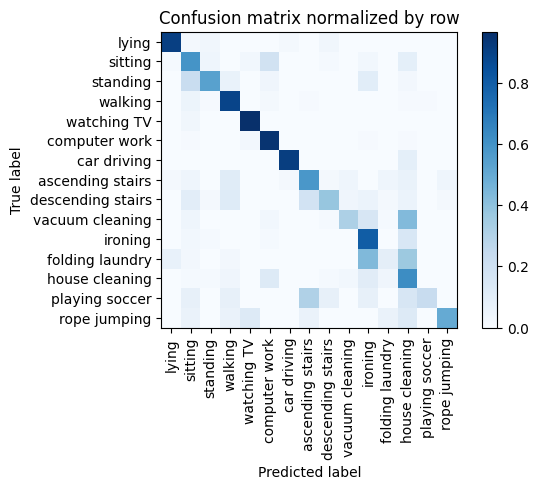

Training Epoch:  70%|███████   | 7/10 [00:25<00:11,  3.73s/it]

Overall accuracy: 0.666



eval: 100%|██████████| 27/27 [00:00<00:00, 63.37batch/s, loss=0.13]


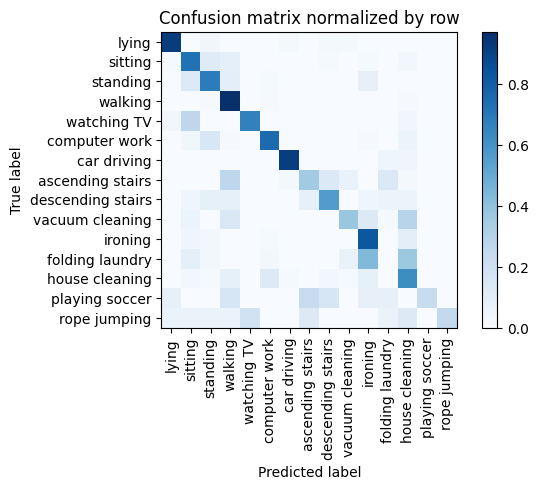

Training Epoch:  80%|████████  | 8/10 [00:29<00:07,  3.79s/it]

Overall accuracy: 0.659



eval: 100%|██████████| 27/27 [00:00<00:00, 67.65batch/s, loss=0.157]


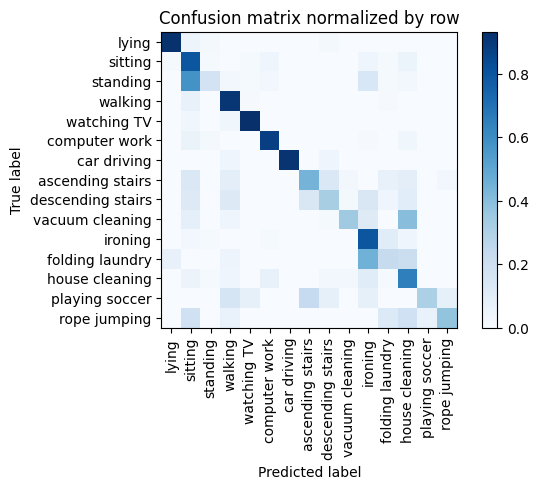

Training Epoch:  90%|█████████ | 9/10 [00:33<00:03,  3.87s/it]

Overall accuracy: 0.643



eval: 100%|██████████| 27/27 [00:00<00:00, 65.38batch/s, loss=0.11]


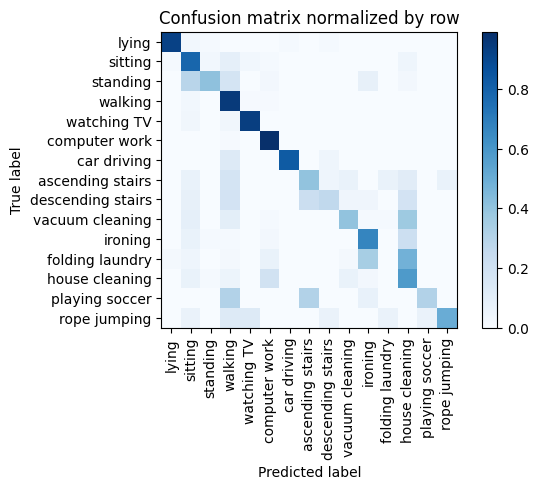

Overall accuracy: 0.652



eval: 100%|██████████| 22/22 [00:00<00:00, 82.09batch/s, loss=0.57] 


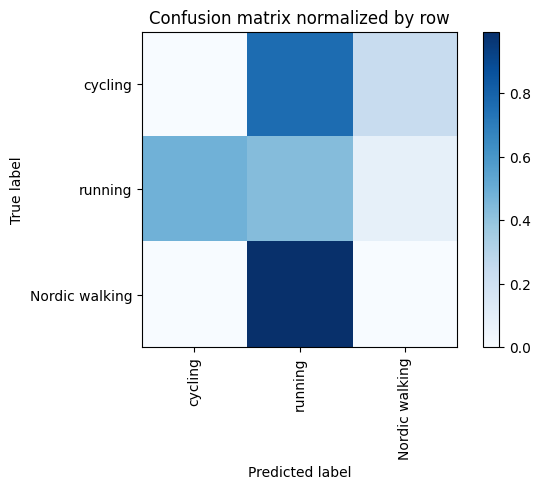

Overall accuracy: 0.091

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.014      0.003      0.006      0.419        287|	 running: 0.993,	cycling: 0.003,	
       cycling       0.000      0.000      0.000      0.375        257|	 running: 0.763,	Nordic walking: 0.237,	
       running       0.113      0.433      0.179      0.206        141|	 cycling: 0.482,	Nordic walking: 0.085,	

----------------------------------------------------------------------------------------------------
   avg / total       0.029      0.091      0.039        1.0        685|	      

{'total_accuracy': 0.0905109489051095, 'precision': 0.04201987965825604, 'recall': 0.14536947801088954, 'f1': 0.06138796169741609}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 64.81batch/s, loss=0.255]


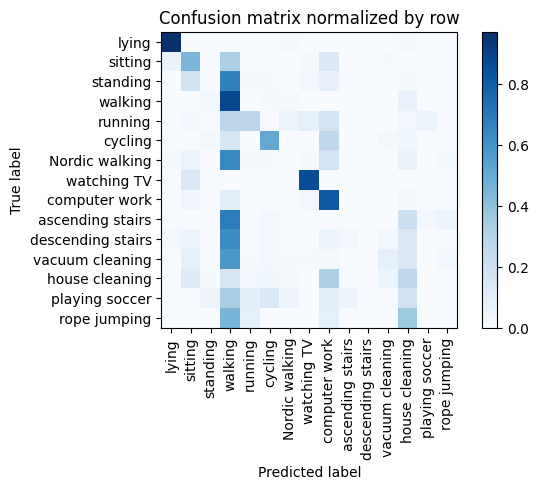

Training Epoch:  10%|█         | 1/10 [00:04<00:38,  4.25s/it]

Overall accuracy: 0.421



eval: 100%|██████████| 28/28 [00:00<00:00, 68.46batch/s, loss=0.219]


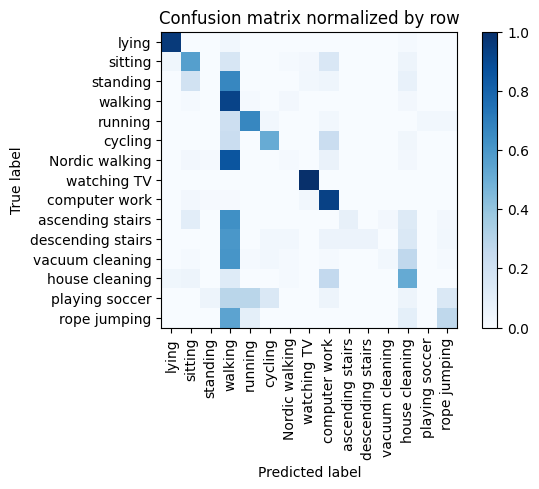

Training Epoch:  20%|██        | 2/10 [00:08<00:33,  4.22s/it]

Overall accuracy: 0.499



eval: 100%|██████████| 28/28 [00:00<00:00, 53.23batch/s, loss=0.177]


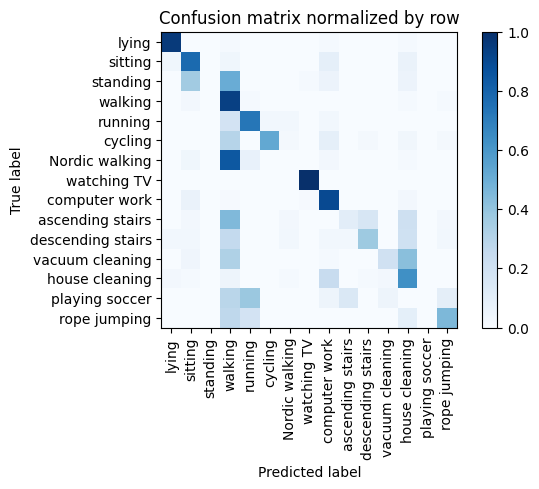

Training Epoch:  30%|███       | 3/10 [00:12<00:29,  4.29s/it]

Overall accuracy: 0.557



eval: 100%|██████████| 28/28 [00:00<00:00, 68.37batch/s, loss=0.19]


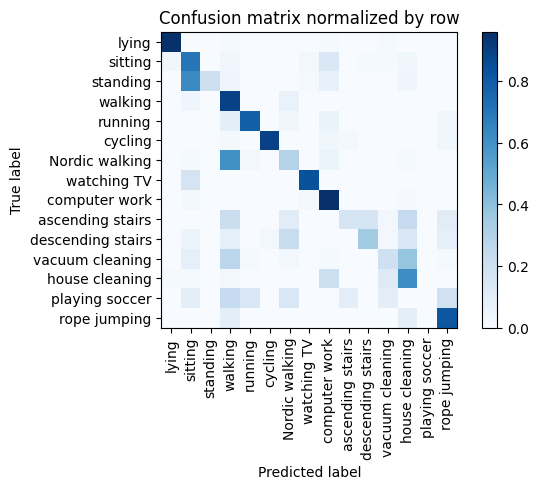

Training Epoch:  40%|████      | 4/10 [00:16<00:25,  4.19s/it]

Overall accuracy: 0.621



eval: 100%|██████████| 28/28 [00:00<00:00, 70.53batch/s, loss=0.154]


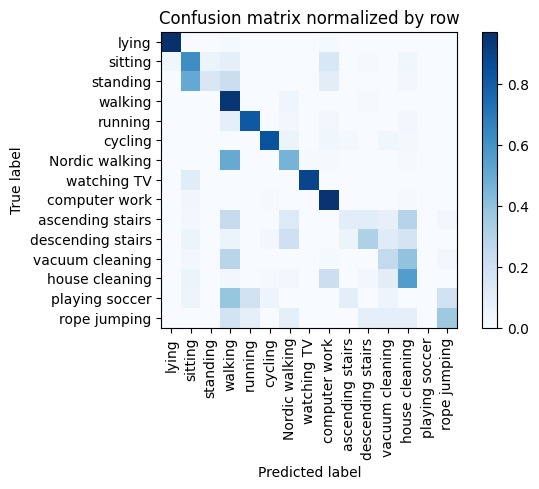

Training Epoch:  50%|█████     | 5/10 [00:20<00:20,  4.09s/it]

Overall accuracy: 0.619



eval: 100%|██████████| 28/28 [00:00<00:00, 65.48batch/s, loss=0.151]


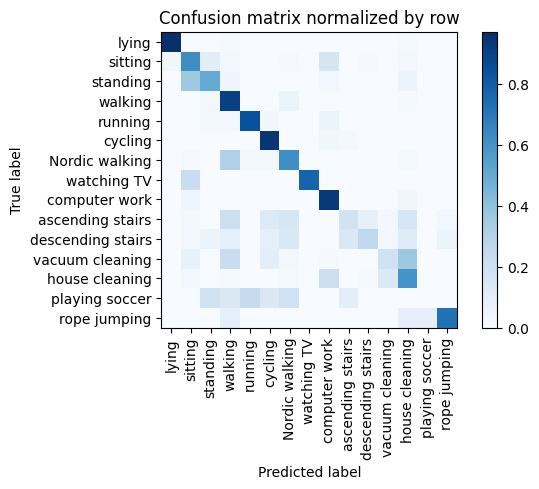

Training Epoch:  60%|██████    | 6/10 [00:24<00:15,  3.97s/it]

Overall accuracy: 0.662



eval: 100%|██████████| 28/28 [00:00<00:00, 75.26batch/s, loss=0.189]


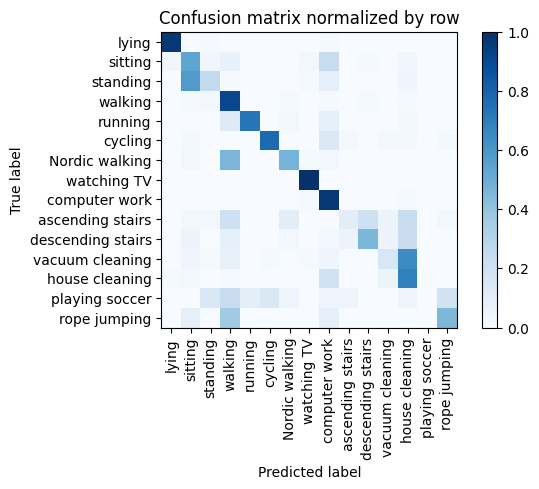

Training Epoch:  70%|███████   | 7/10 [00:28<00:11,  3.90s/it]

Overall accuracy: 0.628



eval: 100%|██████████| 28/28 [00:00<00:00, 63.47batch/s, loss=0.131]


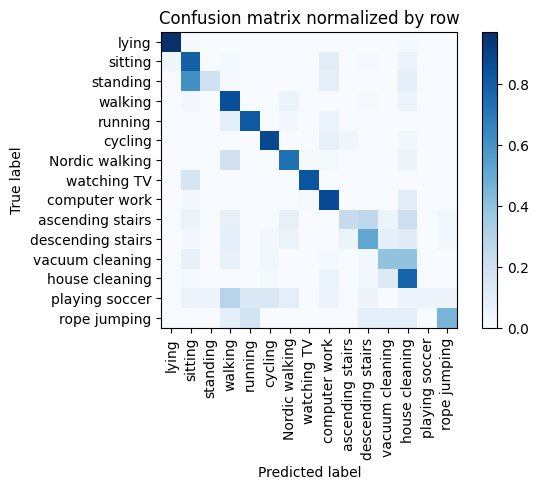

Training Epoch:  80%|████████  | 8/10 [00:32<00:07,  3.88s/it]

Overall accuracy: 0.689



eval: 100%|██████████| 28/28 [00:00<00:00, 76.49batch/s, loss=0.163]


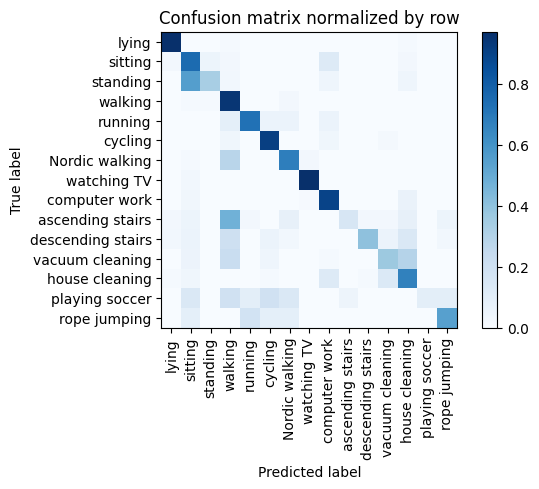

Training Epoch:  90%|█████████ | 9/10 [00:35<00:03,  3.78s/it]

Overall accuracy: 0.690



eval: 100%|██████████| 28/28 [00:00<00:00, 70.48batch/s, loss=0.17]


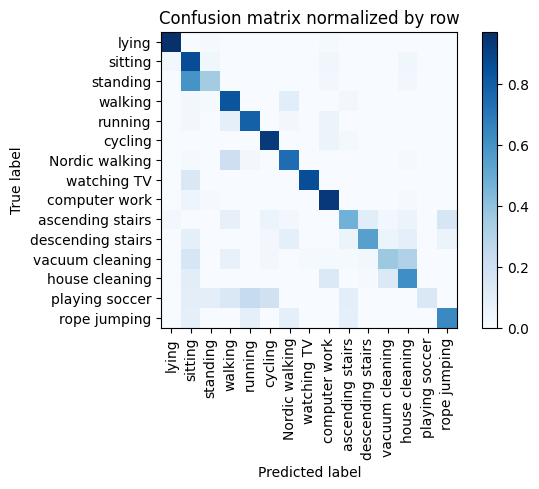

Overall accuracy: 0.719



eval: 100%|██████████| 19/19 [00:00<00:00, 70.11batch/s, loss=0.444]


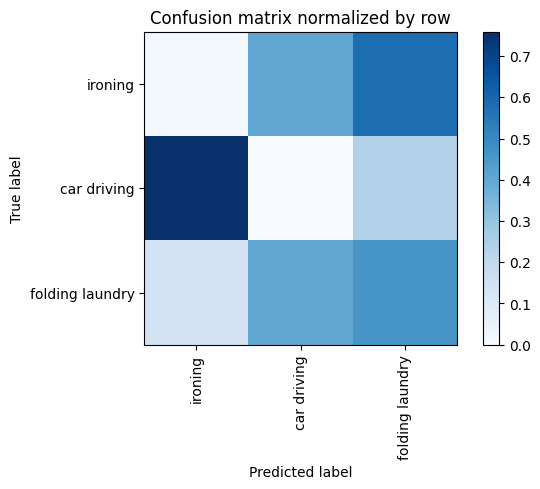

Overall accuracy: 0.134

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.076      0.020      0.031      0.596        357|	 folding laundry: 0.577,	car driving: 0.403,	
folding laundry       0.244      0.459      0.319      0.265        159|	 car driving: 0.403,	ironing: 0.138,	
    car driving       0.000      0.000      0.000      0.139         83|	 ironing: 0.759,	folding laundry: 0.241,	

----------------------------------------------------------------------------------------------------
    avg / total       0.110      0.134      0.103        1.0        599|	      

{'total_accuracy': 0.1335559265442404, 'precision': 0.10674470457079153, 'recall': 0.1595757799975336, 'f1': 0.11665256448909594}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.296499
precision         0.315962
recall            0.291978
f1                0.248496
dtype: float64

In [9]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model4(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len)
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=False)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=False, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    